In [78]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/weather_data_hochiminh_2020.csv', index_col='time', parse_dates=True)

print('Shape of data', data.shape)
data.head(10)


Shape of data (366, 10)


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2020-01-01,28.6,22,35.0,NaN,NaN,47,10.4,NaN,1014.0,NaN
2020-01-02,28.9,23,35.0,NaN,NaN,70,9.8,NaN,1014.2,NaN
2020-01-03,28.6,24,34.0,NaN,NaN,38,7.2,NaN,1013.1,NaN
2020-01-04,27.4,24,33.0,NaN,NaN,43,6.6,NaN,1011.4,NaN
2020-01-05,27.3,23,33.0,NaN,NaN,12,6.7,NaN,1011.5,NaN
2020-01-06,28.6,23,34.0,NaN,NaN,54,7.1,NaN,1011.6,NaN
2020-01-07,29.4,24,35.0,NaN,NaN,98,7.9,NaN,1010.6,NaN
2020-01-08,28.6,25,35.0,NaN,NaN,85,8.4,NaN,1010.3,NaN
2020-01-09,28.7,24,35.0,NaN,NaN,104,8.6,NaN,1009.2,NaN


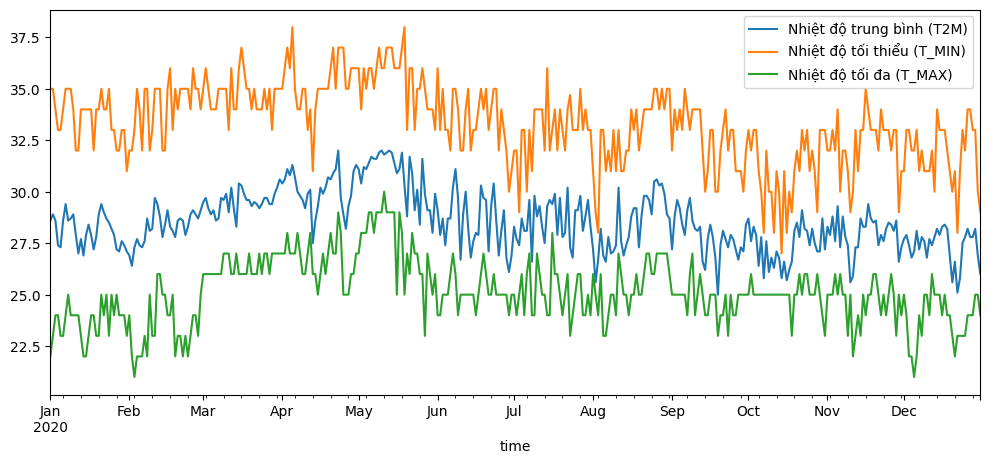

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))


data['tavg'].plot(label='Nhiệt độ trung bình (T2M)')


data['tmax'].plot(label='Nhiệt độ tối thiểu (T_MIN)')


data['tmin'].plot(label='Nhiệt độ tối đa (T_MAX)')


plt.legend()


plt.show()



Check For Stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)
      

In [7]:
adf_test(data['tavg'])

1. ADF :  -2.114969329117273
2. P-Value :  0.23853811649101242
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 356
5. Critical Values :
	 1% :  -3.448853029339765
	 5% :  -2.869693115704379
	 10% :  -2.571113512498422


In [8]:
import pandas as pd

data['differenced'] = data['tavg'].diff()  # Lấy sai phân bậc 1


In [9]:
from statsmodels.tsa.stattools import adfuller

# Kiểm tra tính ổn định của dữ liệu đã được biến đổi
result = adfuller(data['differenced'].dropna(), autolag='AIC')
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("3. Num Of Lags : ", result[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", result[3])
print("5. Critical Values :")
for key, val in result[4].items():
      print("\t",key, ": ", val)

ADF Statistic: -9.737747496140166
p-value: 8.658702416395613e-17
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 356
5. Critical Values :
	 1% :  -3.448853029339765
	 5% :  -2.869693115704379
	 10% :  -2.571113512498422


Figure Out Order for ARIMA Model

In [10]:
from pmdarima import auto_arima

import warnings 
warnings.filterwarnings("ignore")

In [11]:
stepwise_fit = auto_arima(data['tavg'], suppress_warnings= True)

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -482.195
Date:                Fri, 18 Oct 2024   AIC                            970.389
Time:                        10:15:41   BIC                            982.089
Sample:                    01-01-2020   HQIC                           975.039
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3610      0.064      5.597      0.000       0.235       0.487
ma.L1         -0.8521      0.039    -21.692      0.000      -0.929      -0.775
sigma2         0.8207      0.056     14.564      0.000       0.710       0.931
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.72
Prob(Q):                              0.96   Prob(JB):                         0.01
Heteroskedasticity (H):               1.67   Skew:                            -0.35
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
from statsmodels.tsa.arima_model import ARIMA

Split Data into Training and Testing

In [13]:
print(data.shape)
train = data.iloc[:-30]
test = data.iloc[-30:]
print(train.shape, test.shape)
print(test.iloc[0], test.iloc[-1])

(366, 11)
(336, 11) (30, 11)
tavg             27.9
tmin             24.0
tmax             33.0
prcp              NaN
snow              NaN
wdir             57.0
wspd              6.7
wpgt              NaN
pres           1009.7
tsun              NaN
differenced       0.2
Name: 2020-12-02 00:00:00, dtype: float64 tavg             26.0
tmin             24.0
tmax             29.0
prcp              NaN
snow              NaN
wdir             25.0
wspd             13.1
wpgt              NaN
pres           1010.2
tsun              NaN
differenced      -0.9
Name: 2020-12-31 00:00:00, dtype: float64


In [14]:
from pmdarima import auto_arima

# Tìm tham số tốt nhất cho mô hình ARIMA
stepwise_fit = auto_arima(train['tavg'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Hiển thị mô hình
print(stepwise_fit.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=905.337, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=982.840, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=951.588, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=913.219, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=980.842, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=903.337, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=901.674, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=903.292, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=901.741, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=905.227, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=899.693, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=911.239, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=901.356, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=901.310, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=899.7

TRAIN MODEL 

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# Tạo mô hình ARIMA với tham số đã tìm thấy
model = ARIMA(train['differenced'], order=(1,1,1))  
model_fit = model.fit()

# Hiển thị tóm tắt mô hình
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            differenced   No. Observations:                  336
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -482.883
Date:                Fri, 18 Oct 2024   AIC                            971.766
Time:                        10:18:03   BIC                            983.208
Sample:                    01-01-2020   HQIC                           976.328
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3050      0.044     -6.893      0.000      -0.392      -0.218
ma.L1         -0.9997      0.681     -1.469      0.142      -2.334       0.334
sigma2         0.9878      0.669      1.477      0.1

Make Predictions on Test Set

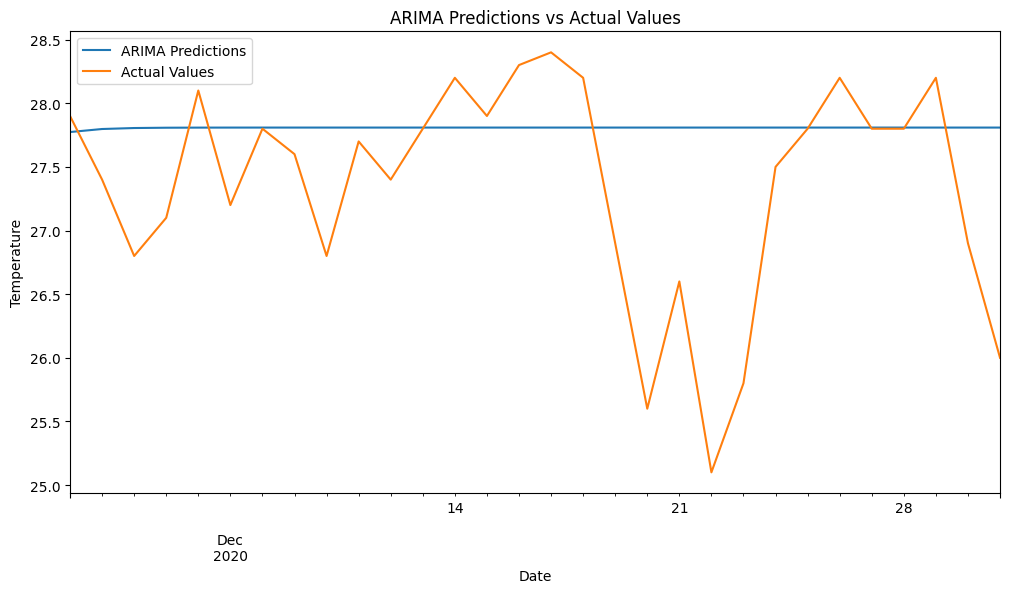

In [22]:



model = ARIMA(train['tavg'], order=(1,1,1))  
model_fit = model.fit()


start = len(train)
end = len(train) + len(test) - 1


pred = model_fit.predict(start=start, end=end, typ='levels')


index_future_dates = pd.date_range(start=test.index[0], end=test.index[-1])

# Gán chỉ số 
pred.index = index_future_dates

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
pred.plot(legend=True, label='ARIMA Predictions')
test['tavg'].plot(legend=True, label='Actual Values')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


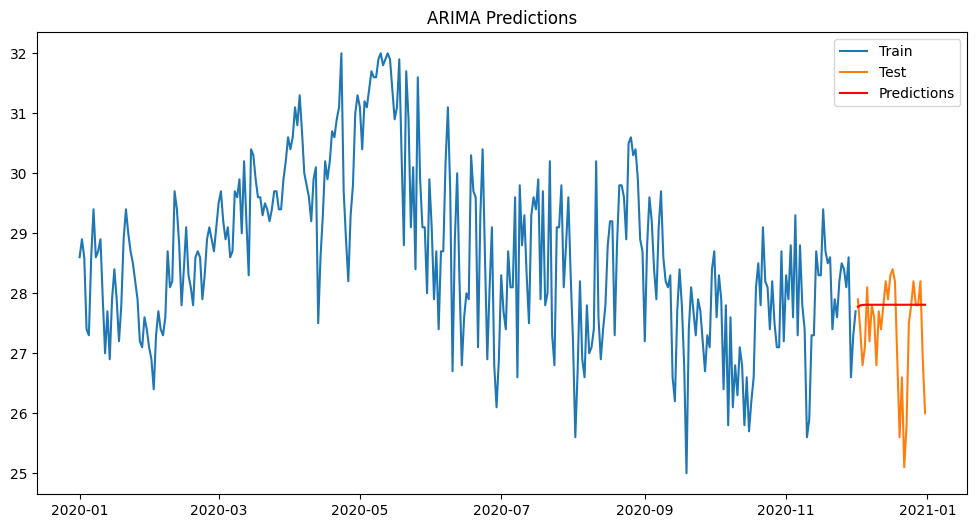

In [23]:
# Dự đoán giá trị cho tập kiểm tra
start = len(train)
end = start + len(test) - 1

pred = model_fit.forecast(steps=len(test))

# Chuyển đổi giá trị dự đoán thành Series để dễ quản lý
pred = pd.Series(pred, index=test.index)

# Vẽ biểu đồ so sánh giữa giá trị thực tế và giá trị dự đoán
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['tavg'], label='Train')
plt.plot(test.index, test['tavg'], label='Test')
plt.plot(pred.index, pred, label='Predictions', color='red')
plt.title('ARIMA Predictions')
plt.legend()
plt.show()


<Axes: xlabel='time'>

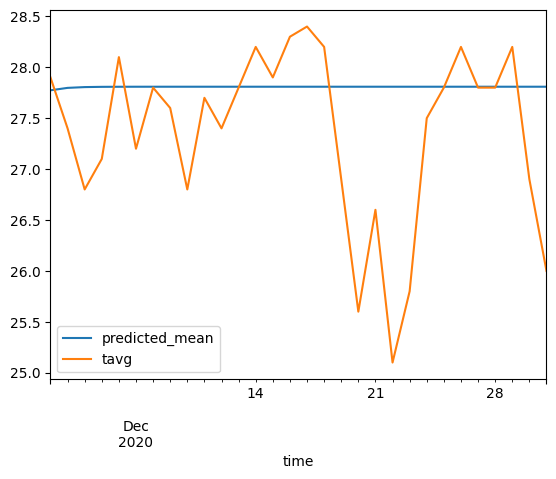

In [24]:
pred.plot(legend='ARIMA Predictions')
test['tavg'].plot(legend=True)

In [25]:
test['tavg'].mean()

27.360000000000003

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['tavg']))
print(rmse)

0.9544409230205914


In [29]:
model2=ARIMA(data['tavg'],order=(1,1,1))
model2=model2.fit()
data.tail()
     

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,differenced
time,,,,,,,,,,,
2020-12-27,27.8,24,34.0,NaN,NaN,332,6.7,NaN,1009.2,NaN,-0.4
2020-12-28,27.8,24,33.0,NaN,NaN,297,6.2,NaN,1008.2,NaN,0.0
2020-12-29,28.2,25,33.0,NaN,NaN,19,7.5,NaN,1008.4,NaN,0.4
2020-12-30,26.9,25,30.0,NaN,NaN,27,13.6,NaN,1009.0,NaN,-1.3
2020-12-31,26.0,24,29.0,NaN,NaN,25,13.1,NaN,1010.2,NaN,-0.9


In [30]:
index_future_dates=pd.date_range(start='2017-12-30',end='2018-01-29')

pred=model2.predict(start=len(data),end=len(data)+30,typ='levels').rename('ARIMA Predictions')

pred.index=index_future_dates
print(pred)


2017-12-30    26.692564
2017-12-31    26.942586
2018-01-01    27.032847
2018-01-02    27.065432
2018-01-03    27.077195
2018-01-04    27.081442
2018-01-05    27.082975
2018-01-06    27.083528
2018-01-07    27.083728
2018-01-08    27.083800
2018-01-09    27.083826
2018-01-10    27.083836
2018-01-11    27.083839
2018-01-12    27.083840
2018-01-13    27.083841
2018-01-14    27.083841
2018-01-15    27.083841
2018-01-16    27.083841
2018-01-17    27.083841
2018-01-18    27.083841
2018-01-19    27.083841
2018-01-20    27.083841
2018-01-21    27.083841
2018-01-22    27.083841
2018-01-23    27.083841
2018-01-24    27.083841
2018-01-25    27.083841
2018-01-26    27.083841
2018-01-27    27.083841
2018-01-28    27.083841
2018-01-29    27.083841
Freq: D, Name: ARIMA Predictions, dtype: float64


<Axes: >

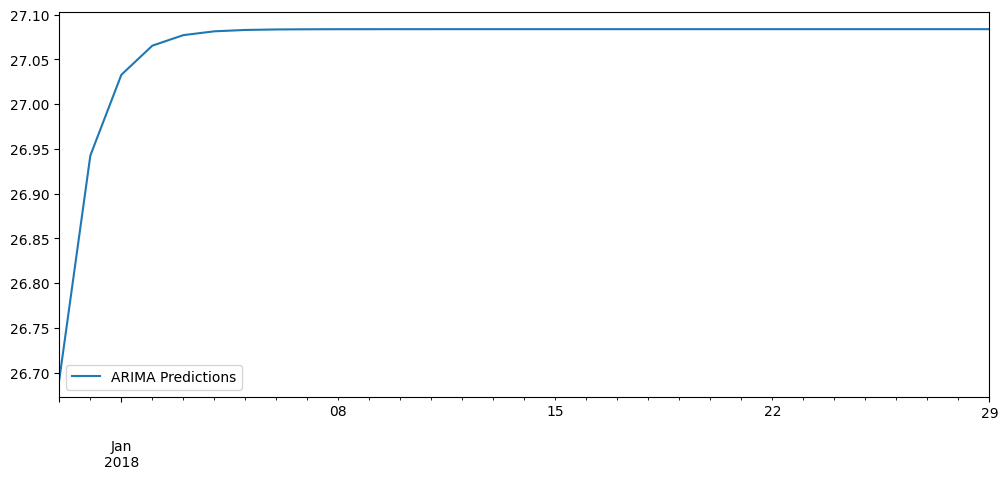

In [31]:
pred.plot(figsize=(12,5),legend=True)